# Brain MRI Tumour Prediction

### Description

This classification task is based on the Kaggle dataset: <a href=https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection>Brain MRI Images for Brain Tumor Detection</a>. The dataset is under public domain license (v10.0).

---
### Table of contents

1. [Dataset](#dataset)
2. [Data preparation](#preparation)
3. [Classification](#classification)
   1. [Simple Conv](#)
   2. [LSTM](#)
   3. [GRU](#)
   4. [Bidirectional](#)
   5. [Conv1d](#)
   6. [FinBERT](#finbert)
4. [Model Comparison](#comparison)

## 1. Dataset

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
from keras.preprocessing.image import ImageDataGenerator
import glob
import seaborn as sns
import random
import cv2
import pathlib
from PIL import Image
import tensorflow as tf

In [2]:
PATH = "data//brain_tumor_dataset//"
no_filenames =[]
yes_filenames = []

for f in os.listdir(PATH+"no"):
    no_filenames.append(f)
    
for f in os.listdir(PATH+"yes"):
    yes_filenames.append(f)

In [3]:
print(len(no_filenames))
print(len(yes_filenames))

98
155


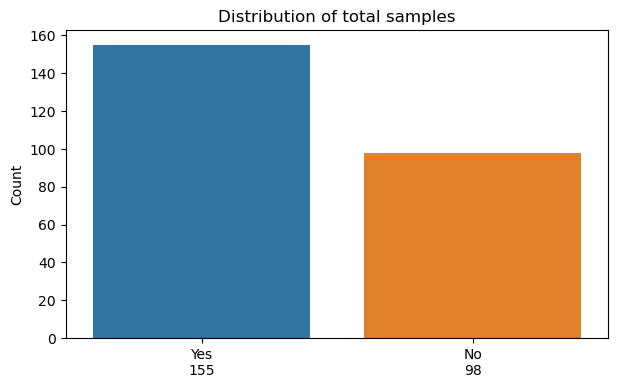

In [4]:
fig = plt.figure(figsize=(7,4))
sns.barplot(x=[f"Yes\n{len(yes_filenames)}",f"No\n{len(no_filenames)}"],y=[len(yes_filenames),len(no_filenames)])
plt.title("Distribution of total samples")
plt.ylabel("Count")
plt.show()

In [5]:

data_dir = pathlib.Path("data/brain_tumor_dataset/")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['no' 'yes']


error: OpenCV(4.7.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x73cf019b::Set<1,-1,-1>,struct cv::impl::A0x73cf019b::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


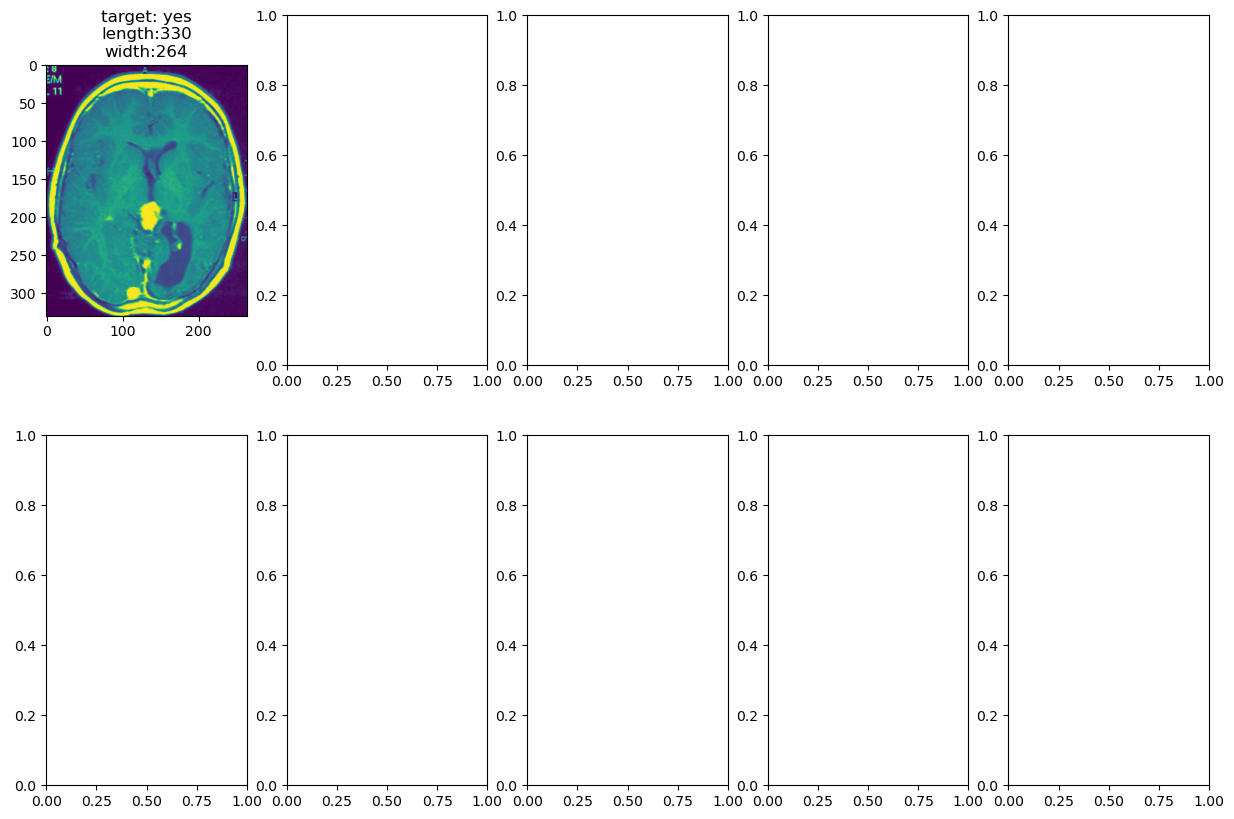

In [6]:
def crop_image(img,tol=0):

    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def view_mri(path,classif):
    fig,axes = plt.subplots(ncols=5,nrows=2,figsize=(15,10))
    random_images = random.sample(os.listdir(path), 5)
    
    for i,im in enumerate(random_images):
        img = plt.imread(path+"/"+im)
        axes[0,i].imshow(img)
        axes[0,i].set_title(f"target: {classif}\nlength:{img.shape[0]}\nwidth:{img.shape[1]}")
        
        im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = crop_image(im_gray,tol=100)
        
        axes[1,i].imshow(img)
        axes[1,i].set_title(f"CROPPED, target: {classif}\nlength:{img.shape[0]}\nwidth:{img.shape[1]}")
        
        
        
view_mri("data/brain_tumor_dataset/yes/","yes")
# view_mri("data/brain_tumor_dataset/no/","no")

## 2. Data Preparation

#### 2.1 Dealing with non uniform-data

In [7]:
ws = []
hs=[]
for img in os.listdir("data/brain_tumor_dataset/yes"):
    im = plt.imread("data/brain_tumor_dataset/yes/"+img)
    #print(im.shape[0],im.shape[1])
    ws.append(im.shape[0])
    hs.append(im.shape[1])
for img in os.listdir("data/brain_tumor_dataset/no"):
    im = plt.imread("data/brain_tumor_dataset/no/"+img)
    #print(im.shape[0],im.shape[1])
    ws.append(im.shape[0])
    hs.append(im.shape[1])  
        
print(max(ws),max(hs))
print(min(ws),min(hs))

1427 1920
127 113


In [8]:
# for img in os.listdir("data/brain_tumor_dataset/no")[:int(len(os.listdir("data/brain_tumor_dataset/no"))*0.8)]:
#     try:
#         im = plt.imread("data/brain_tumor_dataset/no/"+img)
#         im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#         img_gray = crop_image(im_gray,tol=100)
#         # print(type(img_gray))
#         # plt.imsave(img_gray,"data/brain_tumor_dataset/yes/"+img,format="png")
#         # print(img)
#         final_img = Image.fromarray(img_gray).save("data//train//"+img)   
#     except:
#         pass
        

In [9]:
# for img in os.listdir("data/brain_tumor_dataset/no")[int(len(os.listdir("data/brain_tumor_dataset/no"))*0.8):]:
#     try:
#         im = plt.imread("data/brain_tumor_dataset/no/"+img)
#         Image.fromarray(im).save("data//test//no//"+img)   
#     except:
#         pass
        

In [10]:
print("No. of positive samples in train: {}".format(len(os.listdir("data/train/yes/"))))
print("No. of negative samples in train: {}".format(len(os.listdir("data/train/no/"))))
print("No. of positive samples in test: {}".format(len(os.listdir("data/test/yes/"))))
print("No. of negative samples in test: {}".format(len(os.listdir("data/test/no/"))))

No. of positive samples in train: 124
No. of negative samples in train: 77
No. of positive samples in test: 30
No. of negative samples in test: 14


In [11]:
train_dir = "data//train//"
test_dir = "data//test//"

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)


Found 201 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [13]:
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


: 

: 